In [1]:
import sys
sys.path.append(r'C:\Users\maxfu\OneDrive\Documentos\Master\Maximaster\Year 2 - Period 1\Project\Double Pendulum\Double Pendulum')
import numpy as np
from scinet import *
import scinet.pendulum as edo
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from sklearn.feature_selection import mutual_info_regression
from scipy.integrate import odeint

Instructions for updating:
non-resource variables are not supported in the long term


# Data loading and function definition #

Once the program has been trained, we can check the output results.

In [2]:
saved = nn2.Network.from_saved('One unlocked 2N')

{'latent_size': 2, 'input_size': 100, 'input2_size': 1, 'output_size': 2, 'encoder_num_units': [500, 100], 'decoder_num_units': [100, 100], 'tot_epochs': 6000, 'name': 'Unnamed', 'load_file': 'One unlocked 2N'}
INFO:tensorflow:Restoring parameters from C:\Users\maxfu\OneDrive\Documentos\Master\Maximaster\Year 2 - Period 1\Project\Double pendulum\Double Pendulum\tf_save/One unlocked 2N.ckpt
Loaded network from file One unlocked 2N


We define the data generation functions for the predictions.

In [3]:
def derivatives(sol,t,L1,L2,m1,m2):
    
    g=9.81
    Theta_1,Theta_1_dot,Theta_2,Theta_2_dot = sol
    
    C1=np.cos(Theta_1-Theta_2)
    C2=np.sin(Theta_1-Theta_2)
    
    # The first derivative of Theta is named Z, and so the second derivative is named Z_dot
    
    Z_1=Theta_1_dot
    Z_2=Theta_2_dot
    Z_1_dot=(m2*g*np.sin(Theta_2)*C1-m2*C2*(L1*Z_1**2*C1+L2*Z_2**2)-(m1+m2)*g*np.sin(Theta_1))/(L1*(m1+m2*C2**2))
    Z_2_dot=((m1+m2)*(L1*Z_1**2*C2-g*np.sin(Theta_2)+g*np.sin(Theta_1)*C1)+m2*L2*Z_2**2*C2*C1)/(L2*(m1+m2*C2**2))
    
    return Z_1,Z_1_dot,Z_2,Z_2_dot

################################################################################################
    
def gen_input(Theta_1_ini,Theta_2_ini,L1,L2,m1,m2, t_predicted):
    
    t_in = np.linspace(0, 5, 50)
    
    sol_i = np.array([Theta_1_ini,0,Theta_2_ini,0])
    th1,th2=[],[]
    
    for i in range(250):
        
        sol = odeint(derivatives, sol_i, t_in, args=(L1,L2,m1,m2))
        Theta_1,Theta_2 = sol[:,0],sol[:,2]
        th1.append(Theta_1),th2.append(Theta_2)
        
    th1,th2=np.array(th1),np.array(th2)    
    in1 = np.dstack([th1,th2])
    in1 = np.reshape(in1, [250, 2 * 50], order='C')
    in2 = np.reshape(t_predicted, (-1, 1))  
    out = np.dstack([in2,in2]) # This is a dummy filler. We are only interested in the shape.
    out = np.reshape(out, [250, 2], order='C') # dummy filler
    return [in1, in2, out]

################################################################################################


In [4]:
def pendulum_prediction(net, Theta_1_i, Theta_2_i, L1, L2, m1, m2):    

    t_given = np.linspace(0, 10, 250)
    t_predicted = np.linspace(0, 10, 250)
    
    ################################################
    
    # We solve the equations manually to be able to compare our results to what the NN outputs.
    
    sol_i_given = np.array([Theta_1_i,0,Theta_2_i,0])
    sol_given = odeint(derivatives, sol_i_given, t_given, args=(L1,L2,m1,m2))
    Theta_1_given,Theta_2_given=sol_given[:,0],sol_given[:,2]
    
    ################################################
     
    Theta_1_pred,Theta_2_pred=[],[]
    res = net.run(gen_input(Theta_1_i,Theta_2_i,L1,L2,m1,m2,t_predicted), net.output).ravel()
    
    # Because of the way the resulting vector is given, we need to manually separate the data.
    # We know exactly how it is distributed because we made the input in a similar way.
    
    for i in range(len(res)):
        if (i%2==0) or i==0:
            Theta_1_pred.append(res[i])
        else:
            Theta_2_pred.append(res[i])
            
    x1,x2,y1,y2=[],[],[],[]
            
    for j in range(len(Theta_1_pred)):
            
        x1.append(L1*np.sin(Theta_1_pred[j]))
        x2.append(L1*np.sin(Theta_1_pred[j])+L2*np.sin(Theta_2_pred[j]))
        y1.append(-L1*np.cos(Theta_1_pred[j]))
        y2.append(-L1*np.cos(Theta_1_pred[j])-L2*np.cos(Theta_2_pred[j]))
            
    ################################################
    
    # Now we plot. We want to have information of each angle against time, as well
    # as one against another. The position of the pendulum in cartesian coordinates is also relevant.
    
    fig, axs = plt.subplots(2, 2, figsize=(15, 15))
    
    fig.suptitle('Time evolution of the double pendulum \nfor initial angles $\\theta_1$=$\pi$/2 and $\\theta_2$=8$\pi$/15 \n\nParameters: L1={0}, L2={1}, m1={2}, m2={3}'.format("%.2f" % L1, "%.2f" % L2, "%.4f" % m1, "%.4f" % m2))
    
    # The first plot corresponds to the first angle as a function of time.
    
    axs[0,0].plot(t_given, Theta_1_given, color='darkorange', label='Given')
    axs[0,0].plot(t_predicted, Theta_1_pred,'--', color='purple', label='Predicted')
    axs[0,0].set_title('$\\theta_{1}$ (t)')
    axs[0,0].set_xlabel('$t$ [$s$]')
    axs[0,0].set_ylabel('$\\theta_{1}$ [$rad$]')
    axs[0,0].grid()
    axs[0,0].legend(loc='upper right', shadow=True, ncol=1)
    
    # The second plot corresponds to the second angle as a function of time.
    
    axs[0,1].plot(t_given, Theta_2_given, color='darkorange', label='Given')
    axs[0,1].plot(t_predicted, Theta_2_pred,'--', color='purple', label='Predicted')
    axs[0,1].set_title('$\\theta_{2}$ (t)')
    axs[0,1].set_xlabel('$t$ [$s$]')
    axs[0,1].set_ylabel('$\\theta_{2}$ [$rad$]')
    axs[0,1].grid()
    axs[0,1].legend(loc='upper right', shadow=True, ncol=1)
    
    # In the third plot we represent one angle against the other.
    
    axs[1,0].plot(Theta_1_given, Theta_2_given, color='limegreen', label='Given')
    axs[1,0].plot(Theta_1_pred, Theta_2_pred,'--', color='darkgreen', label='Predicted')
    axs[1,0].set_title('$\\theta_{1}$ vs $\\theta_{2}$')
    axs[1,0].set_xlabel('$\\theta_{1}$ [$rad$]')
    axs[1,0].set_ylabel('$\\theta_{2}$ [$rad$]')
    axs[1,0].grid()
    axs[1,0].legend(loc='upper right', shadow=True, ncol=1)
    
    # The last plot shows the trajectory of each mass in cartesian coordinates over time.
    
    axs[1,1].plot(x1,y1,'o',fillstyle='none',color='crimson', label='$m_{1}$')
    axs[1,1].plot(x2,y2,'o',fillstyle='none',color='indigo', label='$m_{2}$')
    axs[1,1].set_title('Trajectory')
    axs[1,1].set_xlabel('$x$ [$m$]')
    axs[1,1].set_ylabel('$y$ [$m$]')
    axs[1,1].grid()
    axs[1,1].legend(loc='upper right', shadow=True, ncol=1)
    
    plt.show()
    

# Plotting of the results #

In [5]:
# We can randomly select the initial parameters. It is important to stay within the range stablished during
# the training, else the NN will fail to make a prediction.

L1=np.random.uniform(1,1)
L2=np.random.uniform(1,1)
m1=np.random.uniform(1,1)
m2=np.random.uniform(1,1.10)

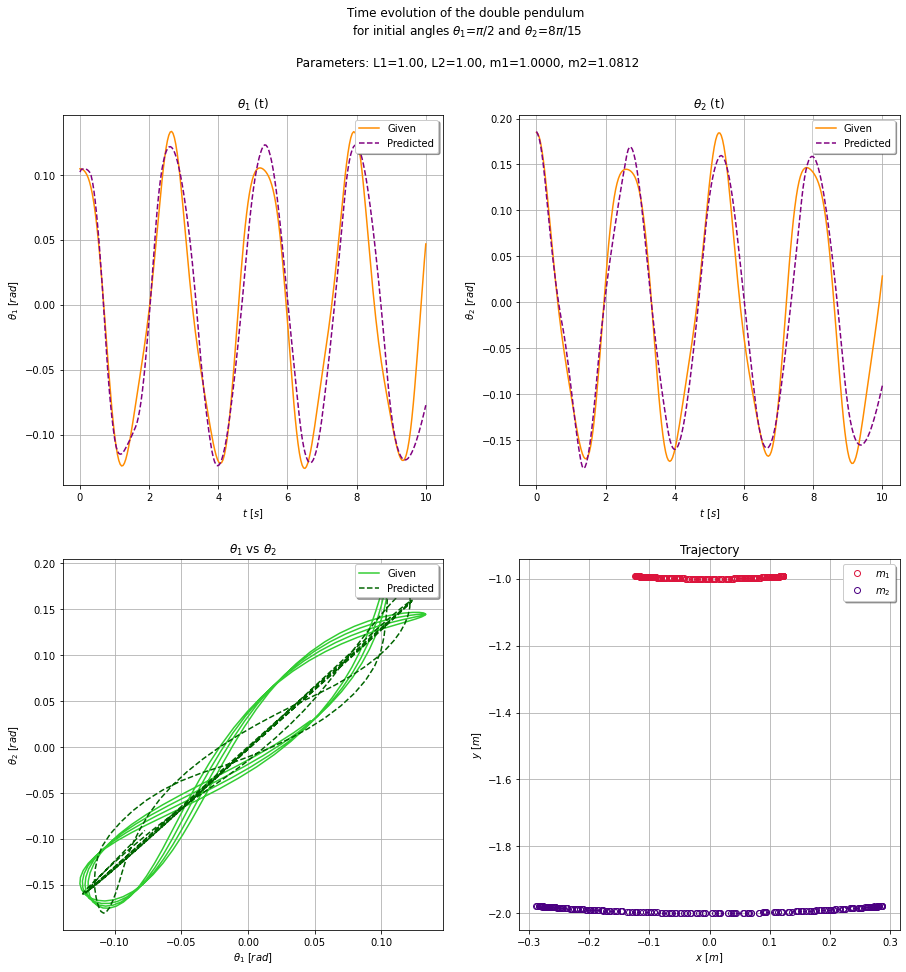

In [6]:
# This cell plots the results. The initial angles should be the ones used during the training (specially for
# angles outside the non-chaotic regime of the pendulum).

pendulum_prediction(saved, np.pi/30, np.pi/17, L1, L2, m1, m2);

# Neuron usage #

This section aims to check how many neurons are used by the NN in each case. 

First of all, we need to define a function that is analogous to gen_input but with only one value for the time.

Next, we define a function that plots the neuron usage of each parameter of the system.

In [7]:
def eval_input(Theta_1_ini,Theta_2_ini,L1,L2,m1,m2,eval_time):
    
    t_in = np.linspace(0, 5, 50)
    t_eval = [eval_time]
    
    sol_i = np.array([Theta_1_ini,0,Theta_2_ini,0])
    th1,th2=[],[]
    sol = odeint(derivatives, sol_i, t_in, args=(L1,L2,m1,m2))
    
    Theta_1,Theta_2 = sol[:,0],sol[:,2]
    th1.append(Theta_1),th2.append(Theta_2)                      
    th1,th2=np.array(th1),np.array(th2) 
    
    in1 = np.dstack([th1,th2])
    in1 = np.reshape(in1, [1, 2 * 50], order='C')
    in2 = np.reshape(t_eval, (-1, 1))  
    out = np.dstack([in2,in2]) # This is a dummy filler. We are only interested in the shape.
    out = np.reshape(out, [1, 2], order='C') # dummy filler
    return [in1, in2, out]

In [8]:
def m_neuron_usage(net, m1_range, m2_range, step_num=100, eval_time=7.5):
    m_1 = np.linspace(*m1_range, num=step_num)
    m_2 = np.linspace(*m2_range, num=step_num)
    m1_grid, m2_grid = np.meshgrid(m_1,m_2)
    out = np.array([net.run(eval_input(np.pi/30, np.pi/17,L1,L2,m1,m2,eval_time), net.mu)[0] for m1,m2 in zip(np.ravel(m1_grid),np.ravel(m2_grid))])
    fig = plt.figure(figsize=(net.latent_size*3.9, 2.1))
    for i in range(net.latent_size):
        zs = out[:, i]
        ax = fig.add_subplot(1,2,i+1, projection='3d')
        Z = np.reshape(zs, m1_grid.shape)
        surf = ax.plot_surface(m1_grid, m2_grid, Z, rstride=1, cstride=1, cmap=cm.viridis, linewidth=0)
        ax.set_xlabel(r'$m_{1}$ [$kg$]')
        ax.set_ylabel(r'$m_{2}$ [$kg$]')
        ax.set_zlabel('Latent activation {}'.format(i + 1))
        if (i==2):
            ax.set_zlim(-1,1) 
        ax.set_zticks([-1,-0.5,0,0.5,1])
    fig.tight_layout()
    return fig

In [9]:
%matplotlib tk
m_neuron_usage(saved, [1,1.10], [1,1.10]);